C:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:201: RuntimeWarning: divide by zero encountered in true_divide
C:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:222: RuntimeWarning: divide by zero encountered in power
C:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:224: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:225: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:268: RuntimeWarning: divide by zero encountered in power


61
Trying w= 185.0
------------
61
Trying w= 185.897435897
------------
61
Trying w= 186.794871795
------------
61
Trying w= 187.692307692
------------
61
Trying w= 188.58974359
------------
61
Trying w= 189.487179487
------------
61
Trying w= 190.384615385
------------
61
Trying w= 191.282051282
------------
61
Trying w= 192.179487179
------------
61
Trying w= 193.076923077
------------
61
Trying w= 193.974358974
------------
61
Trying w= 194.871794872
------------
61
Trying w= 195.769230769
------------
61
Trying w= 196.666666667
------------
61
Trying w= 197.564102564
------------
61
Trying w= 198.461538462
------------
61
Trying w= 199.358974359
------------
61
Trying w= 200.256410256
------------
61
Trying w= 201.153846154
------------
61
Trying w= 202.051282051
------------
61
Trying w= 202.948717949
------------
61
Trying w= 203.846153846
------------
61
Trying w= 204.743589744
------------
61
Trying w= 205.641025641
------------
61
Trying w= 206.538461538
------------
61
Trying

NameError: name 'sys' is not defined

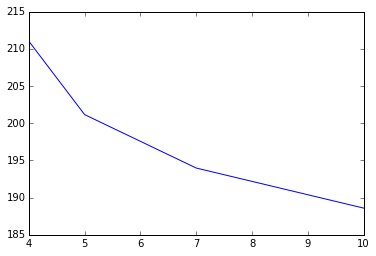

In [3]:
%matplotlib inline

# -*- coding: utf-8 -*-
"""
Created on Tue Dec 16 14:12:58 2014

@author: jgb

Modified on June 8th 2015 by SBT
"""

import unittest
from __future__ import division
from scipy.constants import pi
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
q=1.602E-19
m_Be= 1.5E-26
k_e= 8.9875517873681764E9


class ModeAnalysis():
    q=1.602E-19
    m_Be= 1.5E-26
    k_e= 8.9875517873681764E9
    def __init__(self, shells=4, Vtrap = [0.0,-1750.0,-2000.0], Ctrap = 1.0, 
                 fz=1000, B=4.4588, frot=60, Vwall=1, wall_order=2, mult=1e14):
        self.quiet = False        
        self.Evects = 0 # Eigen vectors
        self.Evals = 0 # Eigen frequencies
        self.dens = 0
        self.avg = 0
        
        self.shells = shells
        self.Nion = 1 + 6* np.sum(range(1,shells+1))
        self.u0 = np.empty(2*self.Nion) # for array of ion positions first half is x, last is y
        self.u = np.empty(2*self.Nion) # for array of ion positions first half is x, last is y
        self.scale = 0
        
        # trap definitions
        self.B = B
        self.m = m_Be * np.ones(self.Nion)
        self.wcyc = q*B/m_Be
        self.C = Ctrap * np.array([[0.0756,   0.5157,   0.4087],
                                   [-0.0001, -0.005,    0.005],
                                   [1.9197e3, 3.7467e3,-5.6663e3],
                                   [0.6738e7,-5.3148e7, 4.641e7]]) #axial trap coefficients
        self.relec = 0.01 #rot wall electrode distance in meters
        self.Vtrap = np.array(Vtrap) #Vend, Vmid, Vcenter
        self.Coeff = np.dot(self.C,self.Vtrap)
        
        self.wz = np.sqrt(2*q*self.Coeff[2]/m_Be)
        self.wrot = 2*pi*frot*1e3
        self.wmag = 0.5*(self.wcyc-np.sqrt(self.wcyc**2-2*self.wz**2))

        self.V0 = (0.5*m_Be*self.wz**2)/q
        self.Vw = self.V0 *0.045*Vwall/1000 #V_T divides in MATLAB
        self.mult = mult
        
        #wall order
        if wall_order == 2:
            self.Cw2 = q*Vwall*1612
            self.Cw3 = 0
        if wall_order == 3:
            self.Cw2 = 0
            self.Cw3 = q*Vwall*3e4

    
  
        
    def run_quiet(self):
        self.quiet = True
        mins = 10e-6
        res = 0.1e-6
        if self.wmag > self.wrot:
            print("Warning: Rotation frequency below magnetron frequency of {0:.1f}".format(float(self.wmag/2*pi)))
            return 0
        self.u0[:] = self.find_scaled_lattice_guess(mins, res)
        self.u = self.find_eq_pos(self.u0)
        
        self.Evals,self.Evects = self.calc_axial_modes(self.u)
        
        #sort arrays
        sort_ind = np.argsort(np.abs(self.Evals))[::-1]
        self.Evals = self.Evals[sort_ind]/(2*pi*1e3) #units of kHz
        self.Evects = self.Evects[:,sort_ind]
        self.r,dx,dy,self.rsep = self.find_radial_separation(self.u)
       
    def run_loud(self):
        self.quiet = False
        mins = 10e-6
        res = 0.1e-6
        if self.wmag > self.wrot:
            print("Warning: Rotation frequency below magnetron frequency of {0:.1f}".format(float(self.wmag/2*pi)))
            return 0
        #Determine an initial scaled lattice guess
        self.u0[:] = self.find_scaled_lattice_guess(mins, res)
        #Compute the equilibrium posisiotn by minimizing the potential energy
        self.u = self.find_eq_pos(self.u0)
        
        #Once the final configuration is found, get the eigenmodes
        self.Evals,self.Evects = self.calc_axial_modes(self.u)
        
        #sort arrays
        sort_ind = np.argsort(np.abs(self.Evals))[::-1]
        self.Evals = self.Evals[sort_ind]/(2*pi*1e3) #units of kHz
        self.Evects = self.Evects[:,sort_ind]
        self.r,dx,dy,self.rsep = self.find_radial_separation(self.u)
       
    
    
    #Iteratively try to make a scaled lattice.
    def find_scaled_lattice_guess(self, mins, res):
        #Make a 2d lattice; u represents the position
        uthen = self.generate_2D_hex_lattice(self.shells, mins)
        #Figure out the lattice's initial potential energy
        pthen = self.pot_energy(uthen)
        
        #Iterate through the range of minimum spacing in steps of res/resolution
        for scale in np.arange(mins+res, (mins/res)*mins, res):
            #Quickly make a 2d hex lattice; perhaps with some stochastic procedure?
            uguess = self.generate_2D_hex_lattice(self.shells, scale)
            #Figure out the potential energy of that newly generated lattice
            pnow = self.pot_energy(uguess)
            
            #And if the program got a lattice that was less favorably distributed, conclude
            #that we had a pretty good guess and return the lattice.
            if pnow >= pthen:
                #print "find_scaled_lattice: Minimum found"
                #print "initial scale guess: " + str(scale)
                self.scale = scale
                return uthen
            #If not, then we got a better guess, so store the energy score and current arrangement
            #and try again for as long as we have mins and resolution to iterate through.
            uthen = uguess
            pthen = pnow
        #If you're this far it means we've given up
        self.scale = scale
        #print "find_scaled_lattice: no minimum found, returning last guess"
        return uthen
    
    #Make a 2d lattice
    #Accepts # of shells and a scale?
    def generate_2D_hex_lattice(self, shells = 1, scale = 1):
        #Start out with the initial 
        posvect =  np.array([0.0,0.0])#always a point [0,0]
        
        for s in range(1,self.shells+1):
            posvect = np.append(posvect, self.add_hex_shell(s)) ## INEFF: instead of appending could fill out
        posvect = scale * posvect
        #Posvect is refolded
        posvect = np.transpose(np.reshape(posvect, (self.Nion,2)))
        #Then refolded again? and returned
        return np.reshape(posvect,2*self.Nion)
    
    #A slave function used to append shells onto a position vector
    def add_hex_shell(self, s):
        a = list(range(s,-s-1,-1)) #Change 1
        a.extend(-s*np.ones(s-1))
        a.extend(range(-s,s+1))
        a.extend(s*np.ones(s-1))
    
        b = list(range(0,s+1))
        b.extend(s*np.ones(s-1))
        b.extend(range(s,-s-1,-1))
        b.extend(-s*np.ones(s-1))
        b.extend(range(-s,0))
        
        x = np.sqrt(3)/2.0 * np.array(b)
        y = 0.5 * np.array(b) + np.array(a)
        pair = np.column_stack((x,y)).flatten()
    
        return pair
    
    #Get the potential energy from a positional array
    def pot_energy(self, pos_array):
        #Frequency of rotation, mass and the number of ions in the array
        w = self.wrot
        m = self.m[0]
        N = int(pos_array.size/2)
        
        #the x positions are the first N elements of the position array
        x = pos_array[0:N]
        #The y positions are the last N elements of the position array
        y = pos_array[N:]
        
        #dx flattens the array into a row and 'normalizes' by subtracting itself to get some zeroes.
        dx = x.reshape((x.size,1)) - x
        dy = y.reshape((y.size,1)) - y
        #rsep is the distances between 
        rsep = np.sqrt(dx**2 + dy**2)   

        #dxsq = np.array([(i-x)**2 for i in x])
        #dysq = np.array([(i-y)**2 for i in y])

        #dxsq = [(i-x)**2 for i in x]
        #dysq = [(i-y)**2 for i in y]
        
        #rsep = np.sqrt(dxsq + dysq)        
        Vc = 1/rsep
        Vc[np.isinf(Vc)|np.isnan(Vc)] = 0
        
        #One half times the rotational force, the charge times the coeff,
        V = 0.5*(-m*w**2 - q*self.Coeff[2] + q*self.B*w) * np.sum((x**2 + y**2)) \
                   - q*self.Coeff[3] *  np.sum((x**2 + y**2)**2) \
                   + np.sum( self.Cw2 *(x**2 - y**2)) \
                   + np.sum( self.Cw3 *(x**3 - 3*x*y**2)) \
                   + 0.5 * k_e * q**2 *np.sum(Vc)
        return self.mult*V
        
    
    def force_penning(self, pos_array):
        w = self.wrot
        m = self.m[0]
        N = int(pos_array.size/2)
        
        x = pos_array[0:N]
        y = pos_array[N:]
        
        dx = x.reshape((x.size,1)) - x
        dy = y.reshape((y.size,1)) - y
        rsep = np.sqrt(dx**2 + dy**2)   
                            
        #Calculate coulomb force on each ion
        Fc = rsep**(-2)
        Fc[np.isinf(Fc)|np.isnan(Fc)] = 0
        fx = np.float64((dx/rsep)*Fc) 
        fy  = np.float64((dy/rsep)*Fc)
        
        
        fx[np.isinf(fx)|np.isnan(fx)] = 0
        fy[np.isinf(fy)|np.isnan(fy)] = 0
        #total force on each ion

        Ftrapx = (-m*w**2 -q*self.Coeff[2] +q*self.B*w +2*self.Cw2) * x \
                    - 4*q*self.Coeff[3]*(x**3+x*y**2) + 3*self.Cw3*(x**2-y**2)
        Ftrapy = (-m*w**2 -q*self.Coeff[2] +q*self.B*w -2*self.Cw2) * y \
                    - 4*q*self.Coeff[3]*(y**3+y*x**2) - 6*self.Cw3*x*y

        #Ftrap =  (m*w**2 + q*self.V0 - 2*q*self.Vw - q*self.B* w) * pos_array
        Fx = -(k_e*q**2)*np.sum(fx, axis = 1) + Ftrapx
        Fy = -(k_e*q**2)*np.sum(fy, axis = 1) + Ftrapy
        
        Fx[np.abs(Fx) < 1e-24] = 0
        Fy[np.abs(Fy) < 1e-24] = 0

        Fx = self.mult*Fx
        Fy = self.mult*Fy
        return np.array([Fx,Fy]).flatten()

    #Deprecated and not used; Cut from this version; go back and get it later if you want
    def hessian_penning(self, pos_array):
        return True
        
    def find_eq_pos(self, u0):
        fun_tolerance = 1e-37
     
        out = optimize.minimize(self.pot_energy, u0, method='BFGS', jac=self.force_penning,
                                options={'gtol': fun_tolerance, 'disp': not self.quiet})
        return out.x
                
    def calc_axial_modes(self, pos_array):
        m = self.m[0]
        N = int(pos_array.size/2)
        A = np.empty((N,N))
        
        x = pos_array[0:N]
        y = pos_array[N:]
        
        dx = x.reshape((x.size,1)) - x
        dy = y.reshape((y.size,1)) - y
        rsep = np.sqrt(dx**2 + dy**2)
        rsep3 = self.nan_to_zero(rsep**-3)
        
        A1 = np.diag((2*q*self.Coeff[2] - k_e*q**2*np.sum(rsep3, axis=0)))
        A2 = k_e*q**2 * rsep3
        A[:] = (A1 + A2)/m
        
        Eval,Evect = np.linalg.eig(A)
        
        Eval = np.lib.scimath.sqrt(Eval)
        
        return Eval, Evect
        
        
    def find_radial_separation(self, pos_array):
        N = int(pos_array.size/2)
        x = pos_array[0:N]
        y = pos_array[N:]
        r = np.sqrt(x**2+y**2)
        
        sort_ind = np.argsort(r)
        r = r[sort_ind]
        x = x[sort_ind]
        y = y[sort_ind]      
        
        dx = x.reshape((x.size,1)) - x
        dy = y.reshape((y.size,1)) - y
        rsep = np.sqrt(dx**2 + dy**2)
        
        return r,dx,dy,rsep
        
    def nan_to_zero(self, my_array):
        my_array[np.isinf(my_array)|np.isnan(my_array)] = 0
        return my_array
        
    def show_crystal(self, pos_vect):
        plt.plot(1e6*pos_vect[0:self.Nion],1e6*pos_vect[self.Nion:],'.')
        #ax.set_aspect('equal')
        plt.xlabel('x position [um]')
        plt.ylabel('y position [um]')
        plt.axes().set_aspect('equal')
        plt.axis([-300,300,-300,300])     
        
        plt.show()
        
    def show_crystal_modes(self, pos_vect, Evects, modes):
        plt.figure(1)
        
        for i in range(modes):
            plt.subplot(modes,1,i+1,aspect='equal')
            plt.scatter(1e6*pos_vect[0:self.Nion],1e6*pos_vect[self.Nion:],c=Evects[:,i], vmin=-.25, vmax=0.25, cmap='RdGy')
            plt.xlabel('x position [um]')
            plt.ylabel('y position [um]')
            plt.axis([-200,200,-200,200])            
        plt.tight_layout()
    
    def get_low_freq_mode(self):
        num_modes = np.size(self.Evals)
        low_mode_freq = self.Evals[-1]
        low_mode_vect = self.Evects[-1]
        
        plt.scatter(1e6*self.u[0:self.Nion],1e6*self.u[self.Nion:],
                    c=low_mode_vect, vmin=-.25, vmax=0.25, cmap='RdGy')
        plt.axes().set_aspect('equal')
        plt.xlabel('x position [um]', fontsize=12)
        plt.ylabel('y position [um]', fontsize=12)
        plt.axis([-300,300,-300,300])
        print(num_modes)
        print("Lowest frequency mode at {0:0.1f} kHz".format(float(np.real(low_mode_freq))))
        return 0
        
    
    def save_positions(self, u):
        np.savetxt("py_u.csv", u, delimiter = ",")
        
    def crystal_spacing_fit(self, r, offset, curvature):
        return np.sqrt(2/(np.sqrt(3)*offset*np.sqrt(1-(r*curvature)**(2))))
      

class TestCalculationConsistency(unittest.TestCase):

    
    def test_073014_axial_frequency_consistency(self):
        """
        Checks to see if the calculation of the axial frequency wz agrees with the
        experimental results from July 30, 2014's data set. This could break if you
        redefined procedures in the Mode Analysis init method.
        """
        a = ModeAnalysis(shells=5 ,Vtrap=[-0.0,-203.0,-421.7], Ctrap = 1.0, frot=177.0, Vwall= 0.10, wall_order=2)
        self.assertTrue(a.wz/(2*pi)*.90<.853E6 and .853E6 <= a.wz/(2* pi)*1.10)
        b = ModeAnalysis(shells=5 ,Vtrap=[-0.0,-423.0,-860.0], Ctrap = 1.0, frot=177.0, Vwall= 0.10, wall_order=2)
        self.assertTrue(b.wz/(2*pi)*.90< 1.253E6 and 1.253E6 <= b.wz/(2* pi)*1.10)
        c = ModeAnalysis(shells=5 ,Vtrap=[-0.0,-863.0,-1740.0], Ctrap = 1.0, frot=177.0, Vwall= 0.10, wall_order=2)
        self.assertTrue(c.wz/(2*pi)*.90< 1.786E6 and 1.786E6 <= c.wz/(2* pi)*1.10)
        d = ModeAnalysis(shells=5 ,Vtrap=[-0.0,-1194.0,-2047.0], Ctrap = 1.0, frot=177.0, Vwall= 0.10, wall_order=2)
        self.assertTrue(d.wz/(2*pi)*.90< 1.865E6 and 1.865E6 <= d.wz/(2* pi)*1.10)
        
    def test_043015_axial_mode_consistency(self):
        """
        Checks to see if the axial frequency (which is identically equal to the COM mode eigenfrequency)
        agrees with the values obtained for varying frot in the lab on April 30th, 2015's data set.
        """
        a = ModeAnalysis(shells=10 ,Vtrap=[-0.0,-1750.0,-2000.0], Ctrap = 1.0, frot=177.5, Vwall= 2.13, wall_order=2)
        a.run_quiet()
        #Using units of hertz
        self.assertTrue(a.wz/(2*pi)*.90<= 1.576E6 and 1.576E6 <= 1.10*a.wz/(2*pi))
        
        #b = ModeAnalysis(shells=10 ,Vtrap=[-0.0,-1750.0,-2000.0], Ctrap = 1.0, frot=180.0, Vwall= 2.13, wall_order=2)
        #b.run_quiet()
        #self.assertTrue(b.wz/(2*pi)*.90<= 1.578E6 and 1.578E6 <= 1.10*b.wz/(2*pi))
    """
    def test_051415_plane_stability(self):
    """
    #Checks to make sure that we start to see a 1-2 plane transistion at appropriate frequencies.
    """
    transsitionseen=False

    while not transsitionseen:
        for w in np.linspace(187,210,10):
            a = ModeAnalysis(shells=10 ,Vtrap=[0.0,-1750.0,-2000.0], Ctrap = 1.0, frot=w, Vwall= 2.13, wall_order=2)
    """
########################################################################################
if __name__ == "__main__":
    #suite = unittest.TestLoader().loadTestsFromTestCase(TestCalculationConsistency)
    #unittest.TextTestRunner(verbosity=1).run(suite)
    shellcounts=[4,5,6,7,8,9,10]
    transistionfreq=[]
    ions=[]
    for s in shellcounts:
        for w in np.linspace(185,220,40):
            a = ModeAnalysis(shells=s ,Vtrap=[0.0,-1750.0,-2000.0], Ctrap = 1.0, frot=w, Vwall= 2.13, wall_order=2)
            a.run_quiet()
            print(a.Nion)
            Evals = a.Evals
            #print(Evals)
            print("Trying w=",w)
            #print("Calculated axial freq:",a.wz/(2*pi))
            if type(Evals) is type(1):
                print("Integer eval obtained:",Evals)
            #else:
                #print(Evals[0])
            if [x for x in Evals if np.imag(x)!=0] != []:
                ions.append(a.Nion)
                transistionfreq.append(w)
                #print([x for x in Evals if np.imag(x) != 0])
                break
            print("------------")
    print(transistionfreq)
    plt.plot(shellcounts,transistionfreq)
    sys.exit()
    """
#    print("Checkpoint Alpha")
#    plt.close()
#    plt.plot((Evals,Evals),(np.ones(np.size(Evals)),np.zeros(np.size(Evals))),linestyle="-",color='black')
#    plt.axis([800,1.550,0,1.1])
#    plt.ylabel('arb')
#    plt.xlabel('Mode Frequency [kHz]')
#    a.show_crystal_modes(a.u, a.Evects, 3)
#    print(np.max(Evals))
#    print(np.min(Evals))
#    plt.close()
    """
    a.show_crystal(a.u)
    #print(a.Nion)

#   get the data    
    r = np.zeros(np.shape(a.r))
    rsep = np.zeros(np.shape(a.rsep))
    r[:] = a.r
    rsep[:]= np.transpose(a.rsep)/a.scale
#    print("Checkpoint Charlie")
    a.get_low_freq_mode()
    #   process into a single 1D array -- use braodcasting to make a r into repeating 
#   2D array (faster than a loop)
    r_full = r + np.zeros(np.shape(rsep)) 
    rsep_flat = rsep.flatten()
    r_flat = r_full.flatten()

#   create mask for points
    rsep_flat[rsep_flat>1.4] = np.nan
    rsep_flat[rsep_flat<0.1] = np.nan
    mask = np.isnan(rsep_flat)
    r_fit = r_flat[~mask]
    rsep_fit = rsep_flat[~mask]

    popt,pcov = optimize.curve_fit(a.crystal_spacing_fit, r_fit, rsep_fit,
                                    p0=[1.25,2000])
    
    pred = a.crystal_spacing_fit(r, *popt)
    plt.figure()
    plt.plot(r_flat/a.scale,rsep_flat,'o')
    plt.plot(r/a.scale,pred,'r')
    plt.ylim(0,2)
    plt.show()
    print(popt)


Vtrap=[0.0,-1750.0,-2000.0], Ctrap = 1.0, frot=w, Vwall= 2.13, wall_order=2


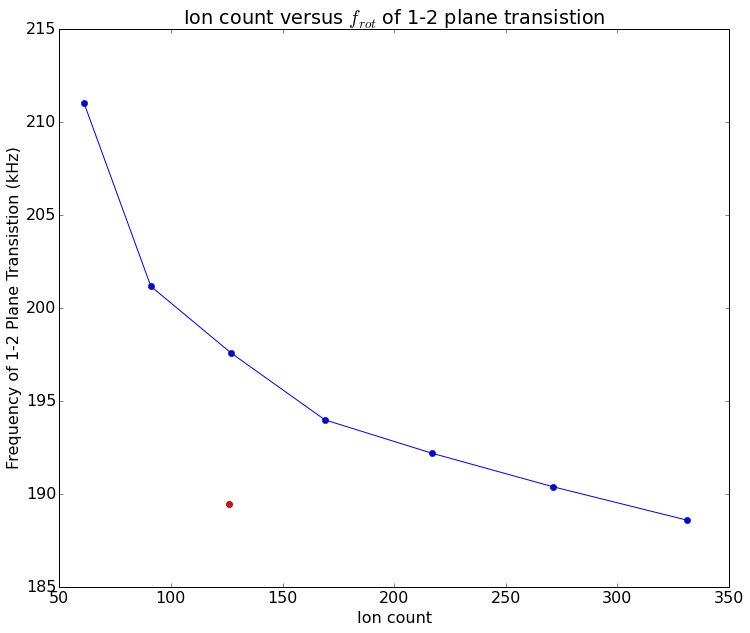

In [9]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(12, 10))
plt.plot(ions,transistionfreq)
plt.plot(ions,transistionfreq,"o",color="blue")
plt.plot(126,189.45,"o",color="red", label="Experiment 05/14/15")
d=plt.xlabel('Ion count')
d=plt.ylabel('Frequency of 1-2 Plane Transistion (kHz)')
d=plt.title('Ion count versus $f_{rot}$ of 1-2 plane transistion')
print("Vtrap=[0.0,-1750.0,-2000.0], Ctrap = 1.0, frot=w, Vwall= 2.13, wall_order=2")

